# Discover data on EODC catalog and read it - Sentinel 1

Earth Observation (EO) data is wide term for data coming from satellite observations of our planet, including satellite imagery (visible and the rest of the electromagnetic spectrum), thermal data, sea level measurements, atmospheric observations and so on. This data can range from "raw" observations from satellite sensors to human-interpretable imagery. Therefore data providers can range from space agencies owning satellites, to companies or research groups which publish processed measurements. Either way, those institutions often give access to picobytes of datasets that are available with different levels of processing and can be accessed with different paradigm. Sometimes it is web interface, sometimes data can be downloaded with Application Programming Interface (API). API is bridge between user, application submitting request, and server, that operates database.

This choice of data providers leads to inconvenience of the user not being aware of what is available, for what region of the world and in which timeframe. Morevoer, usually separate accounts have to be made even for freely available data. For that reasons, community has established SpatioTemporal Asset Catalog (STAC), standard that uses common structure to describe data. In other words, metadata can be accessed with STAC which simplifies data discovery. This metadata can be: provider of satellite imagery, platform (satellite), time moment at which imagery was taken, spatial position and coordinate reference system, acquisition methods and so on. 

Most important metadata of EO data
- Area of interest: bounding box or other polygon consisting of coordinates
- Time range
- Bands of data: polarisation of radar data, visible colors of imagery, etc

Different EO data providers have different APIs and new code has to be written from scratch for each. Therefore, STAC makes this data access easier by cataloging data in common way. It is important to note that with STAC, one can search for data and check what is available, however STAC is not tool developed for downloading datasets. It stores geospatial metadata, which for satellite imagery could be: provider of imagery, description of dataset and acquisition methods, time moment at which imagery was taken, spatial position and coordinate reference system, and so on.

The STAC Specification has four specifications: STAC Item, STAC Catalog, STAC Collection and STAC API. STAC Item is spatiotemporal unit, for instance a SAR image at moment of acquisition. Each must have type (of GeoJSON object), id, STAC version, geometry, bounding box, links (to description, license, quicklook, collection folder, ...), assets (bands of data, ...), and properties (coordinate reference system, ...). Those field names are required, but their structure and what metadata is stored in them is determined by data provider. STAC Catalog links items together, while STAC Collection extends Catalog with information such as links, temporal extent, license and so on.

This notebook shows example of how to access EODC Catalogue with STAC in python, using pystac. EODC is EO data and High Peformance Computing service provider. Firstly, STAC client has to be loaded in python and with it EODC catalogue.

In [40]:
import pystac_client
import folium
from odc import stac as odc_stac


In [41]:

eodc_catalog = pystac_client.Client.open(
    "https://stac.eodc.eu/api/v1"
)

eodc_catalog

<Client id=stac-fastapi>

The URL [https://stac.eodc.eu/api/v1](https://stac.eodc.eu/api/v1), served over Hypertext Transfer Protocol (HTTP), is STAC-compliant API endpoint (specific URL address where API service is available) that leads to EODC Catalogue. Besides EODC, others can be found on [STAC Index](https://stacindex.org/catalogs), such as United States Geological Survey (USGS) Landsat imagery, Sentinel Hub, Copernicus Data Space Ecosystem and so on. Briefly - STAC can be used to search, discover and access metadata of these datasets with same code. [EODC Catalogue](https://services.eodc.eu/browser/#/?.language=en) can be accessed on the web as well.

Each catalog, composed by different providers, has many collections. To get all collections of a catalog, one could print all of them and their ids, which are used to fetch them from the catalog. 

In [42]:
collections = eodc_catalog.get_collections()

max_length = max(len(collection.id) for collection in collections) #length of string of collection.id, for pretty print

for collection in eodc_catalog.get_collections():
    print(f"{collection.id.ljust(max_length)} : {collection.title}")

SENTINEL2_L2A                     : Sentinel-2 MSI Products: Level-2A data
SENTINEL2_GRI_L1C                 : Multi-Layer Copernicus Sentinel-2 GRI in L1C
SENTINEL1_HPAR                    : SENTINEL1 Harmonic Parameters
DOP_AUT_K_KLAGENFURT              : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Klagenfurt
DOP_AUT_K_OSTTIROL                : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Osttirol
DOP_AUT_K_TAMSWEG                 : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Tamsweg
DOP_AUT_K_VILLACH                 : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Villach
DOP_AUT_K_WOLFSBERG               : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Wolfsberg
DOP_AUT_K_ZELL_AM_SEE             : Digital Orthophotos (DOP) Austria - Land Kärnten: Orthofotos Flugblock Zell am See
DOP_AUT_K_ZELTWEG                 : Digital Orthophotos (DOP) Austria - Land K

To get a specific collection from the above list, we should put id into `client.get_collection()` method. It can be displayed with its description, id, temporal and spatial extend, licence, etc. This depends on a provider.

In [43]:
colllection_id = 'SENTINEL1_SIG0_20M'

collection = eodc_catalog.get_collection(colllection_id)
collection

<CollectionClient id=SENTINEL1_SIG0_20M>

Each collection has items, which is one spatio-temporal instance of EO imagery. If items are needed for specific timeframe and for specific region of interest, those could be defined as query in the following way.

In [44]:
#time_range = "2022-01-01/.." # up to current date, an open range
time_range = "2022-10-01/2022-10-07" # closed range

# GEOJSON can be created on geojson.io
# This specific area of interest is a rectangle, but since it is closed polygon it seems like it has five nodes
area_of_interest = {
  "coordinates": [
          [
            [
              17.710928010825853,
              49.257630084442496
            ],
            [
              13.881798300915221,
              49.257630084442496
            ],
            [
              13.881798300915221,
              46.34747715326259
            ],
            [
              17.710928010825853,
              46.34747715326259
            ],
            [
              17.710928010825853,
              49.257630084442496
            ]
          ]
        ],
        "type": "Polygon"
      }

To make the code cleaner, the following bounding box could be used, but generally any area of the world can be selected as polygon (does not have to be a rectangle) with geojson.io and `interescts`.

In [45]:
latmin, latmax = 46.3, 49.3 # South to North
lonmin, lonmax = 13.8, 17.8 # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

From previously loaded catalog with STAC client, a search can be done. Search can have several input parameters, for example if area of interest is specified in geojson format - one should use `interescts`, like below. Another way would be the bounding box, that could be a list, a tuple or iterator, but generally the list should have the following format:

In [46]:
search = eodc_catalog.search(
    collections=colllection_id, # can also be a list of several collections
    bbox=bounding_box, # search by bounding box
    #intersects=area_of_interest, # GeoJSON search
    datetime=time_range,
    # max_items = 1 # number of max items to load, if commented it will load all of them
)

items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 52 items for the given search query


Now, a single item, in this case SAR image, can be fetched and good practice is to check what metadata provider stored on item level.

In [47]:
items_eodc[0]

<Item id=SIG0_20221007T170811_A117_E048N015T3_EU020M_V1M1R1_S1AIWGRDH>

Lets display only VV polarisation of the item and information about data.

In [48]:
items_eodc[0].assets['VV'].extra_fields.get('raster:bands')[0]

{'scale': 10,
 'nodata': -9999,
 'offset': 0,
 'data_type': 'int16',
 'spatial_resolution': 20}

For instance, in EODC catalogue an item can conveniently be displayed with thumbnail.

In [49]:
items_eodc[0].assets['thumbnail'].href

'https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E048N015T3/SIG0_20221007T170811__VV_A117_E048N015T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif/thumbnail'

Here is a way to quickly check how the data found by search query looks on a map.

In [50]:
map = folium.Map(location=[(latmin+latmax)/2, (lonmin+lonmax)/2], zoom_start=7,
                                  zoom_control=False,
                                  scrollWheelZoom=False,
                                  dragging= False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

for item in items_eodc:
    image_url = item.assets['thumbnail'].href # url leading to display of an item, can also be used as hyperlink
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]], # bounds of item
        ).add_to(map)

folium.LayerControl().add_to(map)

map

## Data Reading

STAC can be useful tool for discovery of data, however it only loads metadata. This saves memory, but if one would like to do further analysis the data has to be loaded into memory or downloaded on disk.

Library used for loading data is odc-stac.


In [51]:
bands = ("VV", "VH")
crs = "EPSG:4326" # Coordinate Reference System - World Geodetic System 1984 (WGS84) in this case 
res = 0.00018 # 20 meter in degree

sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time':5}, # this is size of DataArray chunk, how much time instances are loaded at once
                        resolution=res,
                        bbox=bounding_box,
                        )

Lets display for example VV band of the dataset.

In [52]:
sig0_ds.VV

<xarray.DataArray 'VV' (time: 31, latitude: 16667, longitude: 22223)> Size: 23GB
dask.array<VV, shape=(31, 16667, 22223), dtype=int16, chunksize=(5, 16667, 22223), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 133kB 49.3 49.3 49.3 49.3 ... 46.3 46.3 46.3
  * longitude    (longitude) float64 178kB 13.8 13.8 13.8 ... 17.8 17.8 17.8
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2022-10-01T05:09:56 ... 2022-10-0...
Attributes:
    nodata:   -9999

Displayed data is "lazily" loaded, which means that structure of DataArray is constructed, but data is not loaded yet. It is loaded only at instance when it is needed, for example plotting, computing and so on. Dask library then constructs graphs with order of operations that plotting will be done, so that is the way to handle large datasets.  In this example, we have 31 time instances, or 31 items.

Nevertheless, it is better to choose smaller area.

In [53]:
latmin_smaller, latmax_smaller = 48, 48.4
lonmin_smaller, lonmax_smaller = 16, 16.5

smaller_bounding_box = [[latmin_smaller, lonmin_smaller],
                        [latmax_smaller, lonmax_smaller]]

map = folium.Map(location=[(latmin_smaller+latmax_smaller)/2, (lonmin_smaller+lonmax_smaller)/2], zoom_start=8,
                 zoom_control=False,
                 scrollWheelZoom=False,
                 dragging= False)

folium.GeoJson(area_of_interest, name="Area of Interest").add_to(map)

folium.Rectangle(
    bounds=smaller_bounding_box,
    color="red",
).add_to(map)

for item in items_eodc:
    image_url = item.assets['thumbnail'].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
        ).add_to(map)

folium.LayerControl().add_to(map)

map

In [54]:
sig0_ds = odc_stac.load(items_eodc,
                        bands=bands,
                        crs=crs,
                        chunks={'time':5},
                        resolution=res,
                        bbox=[lonmin_smaller, latmin_smaller, lonmax_smaller, latmax_smaller],
                        #groupby='time'
                        )

sig0_ds.VV

<xarray.DataArray 'VV' (time: 31, latitude: 2223, longitude: 2779)> Size: 383MB
dask.array<VV, shape=(31, 2223, 2779), dtype=int16, chunksize=(5, 2223, 2779), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 18kB 48.4 48.4 48.4 48.4 ... 48.0 48.0 48.0
  * longitude    (longitude) float64 22kB 16.0 16.0 16.0 16.0 ... 16.5 16.5 16.5
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2022-10-01T05:09:56 ... 2022-10-0...
Attributes:
    nodata:   -9999

Now dataset is considerably smaller. Lets plot first time instance.

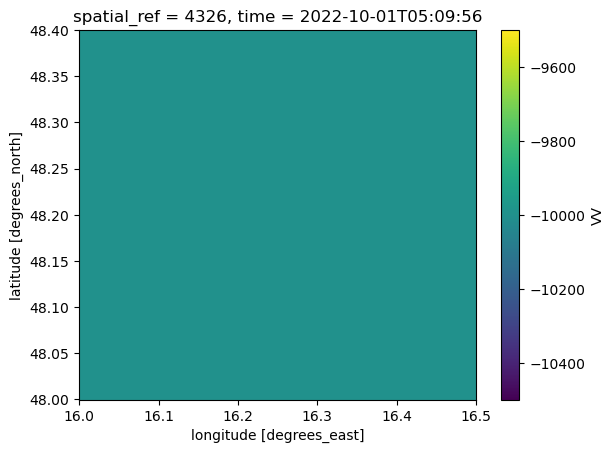

In [55]:
sig0_ds.VV.isel(time=0).plot()

As bounding box could "slice" tiles, that are defined by data provider - sometimes there is no data, in this case as -9999. This visible on previous plot, so nodata has to be disregarded. Furthermore, to save the memory, EODC multiplied data by factor of 10. To store integers (e.g. 25), instead of floats (e.g. 2.5).

As Sentinel-1 satellites overpasses Austria every few days and does acquisition of backscatter for few minutes, only some part of dataset will have physical data. So it is better to take daily averages (average scene that Sentinel observed for few minutes of overpass) and to see how it looks over whole week (that was previously defined in STAC search).

Note: cell belows will take some time to run.

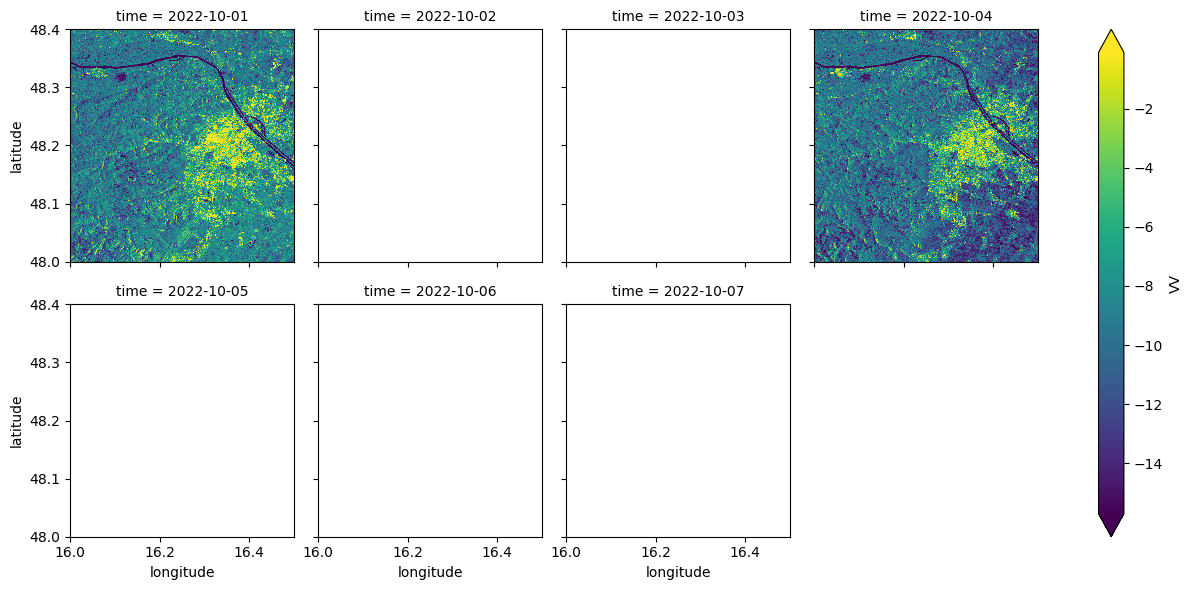

In [56]:
scale = items_eodc[0].assets['VV'].extra_fields.get('raster:bands')[0]['scale'] # raster:bands is STAC raster extension
nodata = items_eodc[0].assets['VV'].extra_fields.get('raster:bands')[0]['nodata']

sig0_ds = sig0_ds.where(sig0_ds != nodata) / scale

daily_averages = sig0_ds.resample(time='1D').mean()
daily_averages.VV.plot(col='time', col_wrap=4, robust=True)

To see a bit better how scene looked over one day:

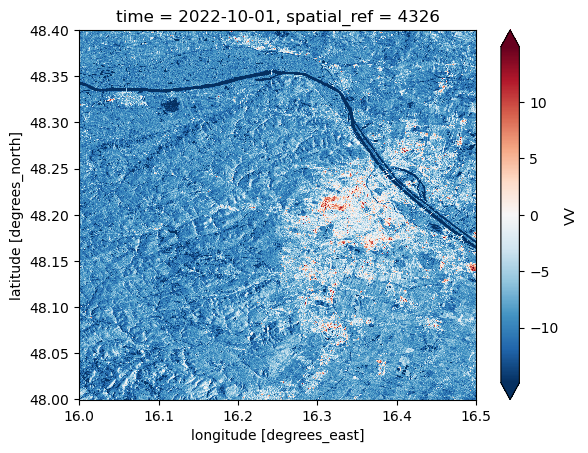

In [39]:
daily_averages.VV[0].plot(robust=True) # robust argument does not display outliers